In [1]:
# import libraries to use
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
import cv2
from sklearn.externals import joblib
from aux_functions import *
from scipy.ndimage.measurements import label
%matplotlib inline

## Reading Car-NoCar Images

We start by reading the set of images that are going to be use to train our classifier. This images have been processed and we can consume them directly.

Let's store two lists with the file name of each image.

In [2]:
# Read in car and no car images
car_images = glob.glob('./image_set/vehicles/*.png')
no_car_images = glob.glob('./image_set/non-vehicles/*.png')
cars = []
notcars = []

for image in car_images:
    cars.append(image)
for image in no_car_images:
    notcars.append(image)

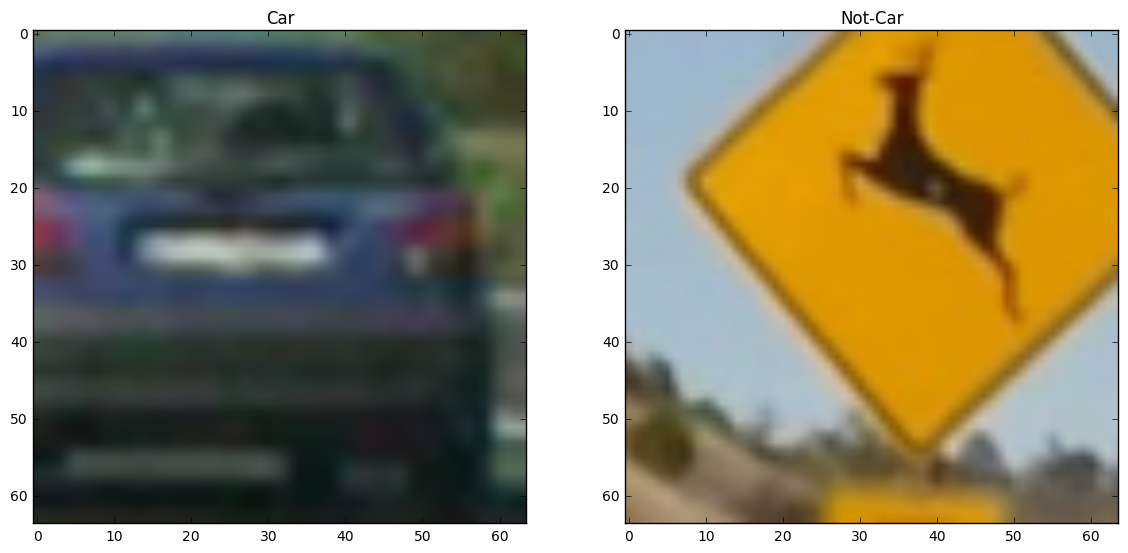

In [3]:
# helper function to make ploting shorter
def toRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Sample images
fig, ax = plt.subplots(1,2)
sample_car = cv2.imread(cars[np.random.randint(0,len(cars))])
sample_notcar = cv2.imread(notcars[np.random.randint(0,len(notcars))])
ax[0].imshow(toRGB(sample_car))
ax[1].imshow(toRGB(sample_notcar))
ax[0].set_title('Car')
ax[1].set_title('Not-Car')
fig.set_size_inches(14,8)

In [4]:
sample_car.shape

(64, 64, 3)

## Histogram of Oriented Gradients (HOG)

I made use of many of the functions defined during the lessons. Some of them have been modified to fit my pipeline. In this case, I use get_hog_features as it is defined in the file aux_functions.py. This function has as input an image, the number of orientations, the number of pixels per block and the number of cells per block.

### Pixels per Cell

The pixels per cell define how many pixel are voting to accumulate a histogram of edge orientations

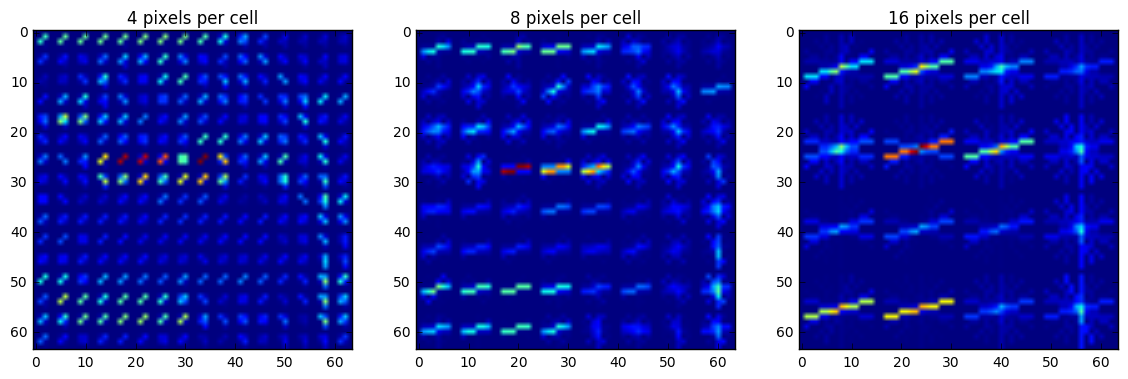

In [5]:
# Example of different pixels per cell considered for the classifier
# form of function get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
fig, ax = plt.subplots(1,3)
pix_grid = [4, 8, 16]
for a, p in zip(ax, pix_grid):
    a.imshow(get_hog_features(sample_car[:,:,1], 9, p, 2, vis=True, feature_vec=False)[1])
    a.set_title(str(p) + ' pixels per cell')
fig.set_size_inches(14,8)

### Orientations

As the gradient can have any orientation between 0 and 360 degrees, a number of bins is defined to create the histogram. These are the orientations on the algorithm.

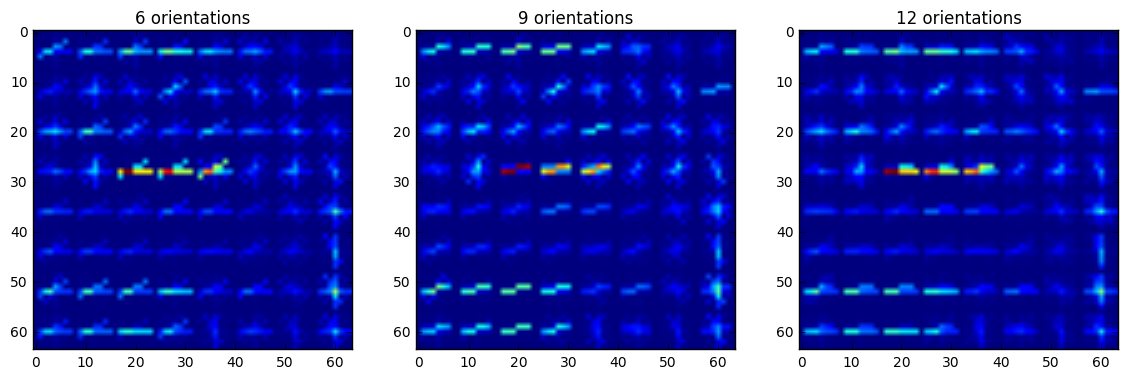

In [6]:
# Example of different binning of orientations
p = 8
fig, ax = plt.subplots(1,3)
orient_grid = [6, 9, 12]
for a, o in zip(ax, orient_grid):
    a.imshow(get_hog_features(sample_car[:,:,1], o, p, 2, vis=True, feature_vec=False)[1])
    a.set_title(str(o) + ' orientations')
fig.set_size_inches(14,8)

### Cells

In order to provide better illumination invariance, the algorithm normalizes the cells across larger areas. Each area is a block. Another parameter to tune is the number of blocks in each cell

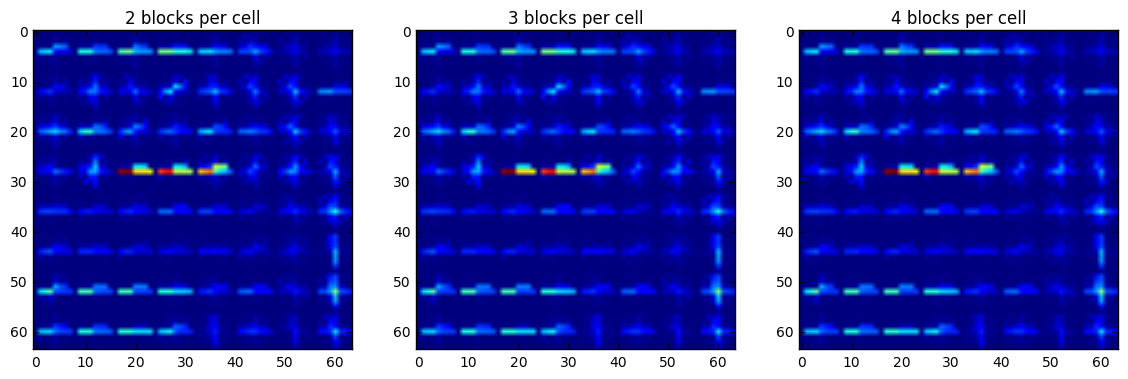

In [7]:
# Example of different blocks per cell
o = 10
fig, ax = plt.subplots(1,3)
cell_grid = [2, 3, 4]
for a, c in zip(ax, cell_grid):
    a.imshow(get_hog_features(sample_car[:,:,1], o, p, c, vis=True, feature_vec=False)[1])
    a.set_title(str(c) + ' blocks per cell')
fig.set_size_inches(14,8)

### Parameter Selection

I tried to follow a systematic approach to selecting the parameters. For that, I trained and tested the classifier with a range of values in each parameter. Given that the test matrix becomes quite large quite fast, I decided to test one parameter at a time. There is an implicit assumption on this. Each parameter has to be independent of each other with relation to the performance of the classifier. That is very likely not the case. However, a good estimated value of what works can be found. This process is presented in the notebook [Optimize HOG Detector](./Optimize HOG Detector.ipynb)

For the final classifier I used 10 orientations, 8 pixels per cell, 2 cells per block and I used all channels of colorspace YCrCb

### Classifier

For my classifier I used a SVM. For the features I did not just use what I obtained with HOG but I also used spatial binned of color features and color histograms. This creates quite a high number of features. For this reason, we run the risk of over-fitting our data, but it is worth a try.

To decide on what parameters to use for spatial binning and histogram binning of color, I wrote a function that given those parameters trains and test a SVM classifier. That function is defined in the notebook [Optimize Color Detector](./Optimize Color Detector) in cell 7. That function allows me to sweep the parameter space as defined in cell 6 of that same notebook. Computing all those models is quite expensive and for that reason I restricted the calculation somehow.

The best combination of parameters for color classifier is given by using a spatial binning of 8 and a histogram binning of 32 with a LUV colorspace.

With this parameters I fit a SVM in function svm_car_classifier. That function is very similar to the one used in the mentioned notebooks but it can be configured to use color and hog features. Given that those features can be different, a scaling is calculated in line 141 and applied in line 143. After that is just a matter of using sklearn to train the model in line 161 and test it in line 163. This function returns both the model, the scaler and its score.

In [8]:
# Simplified call. Defaults in the imported code are set to the best found
# uncomment following line to calculate
classifier, scaler, score = svm_car_classifier(cars, notcars)
joblib.dump(classifier, 'final_svm.pkl')
joblib.dump(scaler, 'final_scaler.pkl')
classifier = joblib.load('final_svm.pkl')
scaler = joblib.load('final_scaler.pkl')

Trainning model with binning of: 8 and 32 histogram bins, color LUV
Using: 10 orientations 8 pixels per cell and 2 cells per block in channel ALL with colorspace YCrCb
Features: 6168
Test Accuracy of SVC =  0.9902


Let's run the classifier in predicting mode on some samples to check that it works as it should

In [9]:
# To simplify code I use the default values set in aux_functions.py. Those are set with optimum values found before
success_car = 0
n = 100
for i in range(n):
    car_test = cars[np.random.randint(0,len(cars))]
    image = cv2.imread(car_test)
    car_feat = single_im_extract(image)
    car_feat_scaled = scaler.transform(car_feat)
    success_car += classifier.predict(car_feat_scaled).sum()
success_notcar = 0
for i in range(n):
    notcar_test = notcars[np.random.randint(0,len(notcars))]
    image = cv2.imread(notcar_test)
    notcar_feat = single_im_extract(image)
    notcar_feat_scaled = scaler.transform(notcar_feat)
    success_notcar += classifier.predict(notcar_feat_scaled).sum()
print('The classifier predicted correctly', success_car, 'images out of', n, 'images of cars')
print('The classifier predicted correctly', n - success_notcar, 'images out of', n, 'images of not cars')

The classifier predicted correctly 100.0 images out of 100 images of cars
The classifier predicted correctly 100.0 images out of 100 images of not cars


## Sliding Window Search

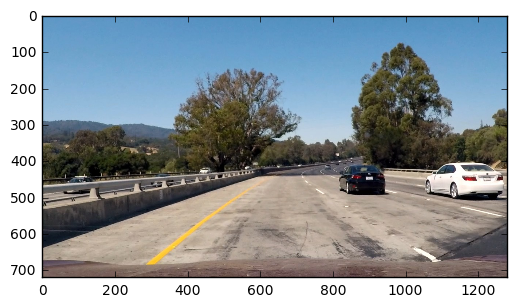

In [10]:
test_image = cv2.imread('./test_images/test1.jpg')
plt.imshow(toRGB(test_image))

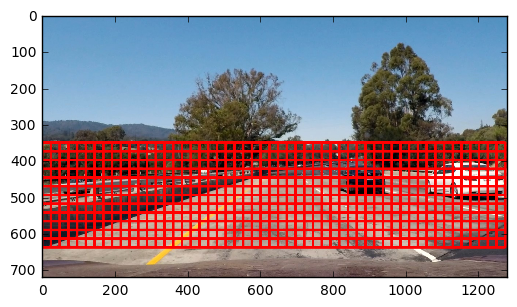

In [11]:
boxes = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[350, 650],
             xy_window=(96, 96), xy_overlap=(0.75, 0.75))
plt.imshow(toRGB(draw_boxes(test_image, boxes)))

In [12]:
debug_images_1 = []
# To simplify code I use the default values set in aux_functions.py. Those are set with optimum values found before
def search_windows(image, windows, classifier, scaler):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        global debug_images_1
        debug_images_1.append(test_img)
        #4) Extract features for that window using single_img_features()
        # I use default values set in the definition of the function
        features = single_im_extract(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = classifier.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Let's check how this works in test images

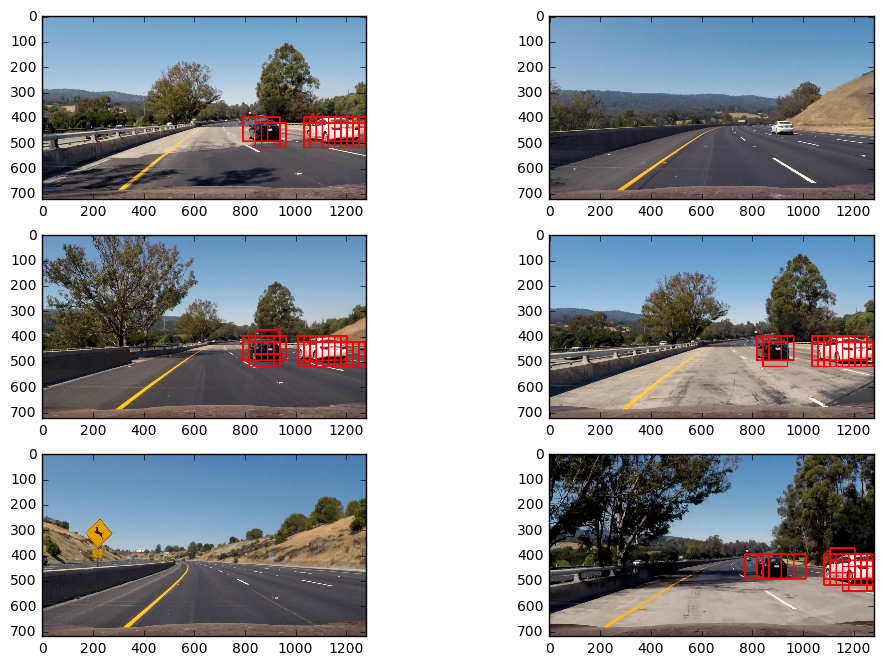

In [13]:
test_images = glob.glob('./test_images/*')
fig, ax = plt.subplots(3,2)
for a, image in zip(ax.flatten(), test_images):
    im = cv2.imread(image)
    car_located = search_windows(im, boxes, classifier, scaler)
    a.imshow(toRGB(draw_boxes(im, car_located)))
fig.set_size_inches(12,8)

The system seems to be working quite well already with this parameters. However, it has problems detecting small cars. That is to be expected as we are using just one scale for the boxes. I could use this procedure to find boxes of different sizes. That would be computationally inefficient. The proposed method of calculating hog features for the region of interest and then using sub-sampling seems to be a better approach. In the following part I would use a modified version of find_cars to use that approach. Let's repeat the test using that function. 

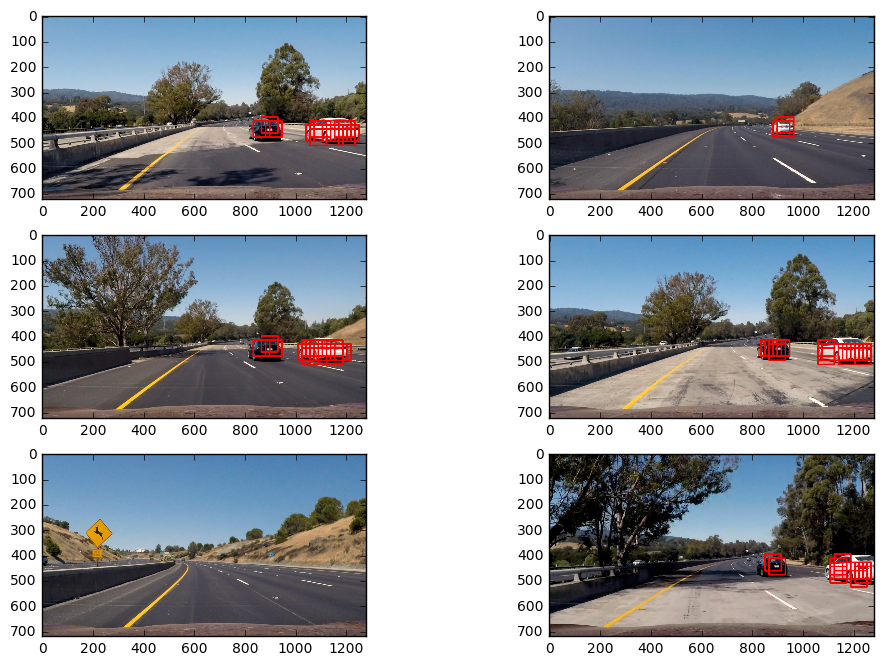

In [14]:
ystart = 350
ystop = 650
scale = 1  # equivalent to our previous search but with box stepping of 64 pixels
test_images = glob.glob('./test_images/*')
fig, ax = plt.subplots(3,2)
for a, image in zip(ax.flatten(), test_images):
    im = cv2.imread(image)
    found_cars = find_cars(im, ystart, ystop, scale, classifier, scaler)
    a.imshow(toRGB(draw_boxes(im, found_cars)))
fig.set_size_inches(12,8)

It is not perfect but it looks good. Processing the image with a small sliding window creates some false positives. Depending of how far we want cars to be detected this is a parameter to tune. Using a small window also makes the search slower. Therefore, we need to be carefull here.

## Filtering Results

Next, we will look at creating a heat map to improve our detection. To do that, we look for cars at different scales. Functions to define an calculate the heat map are included in [aux_functions.py](./aux_functions.py). They are pretty much the same the was use in class. Here we select 4 different scales that seem to work well on test images.

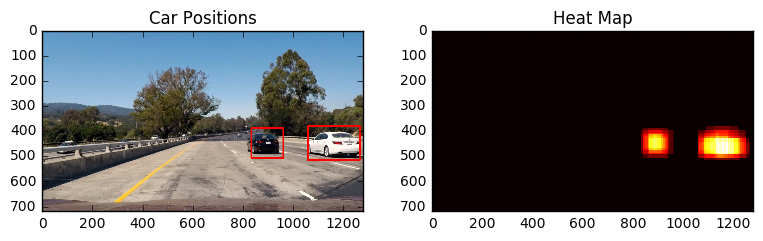

In [15]:
car_boxes = []
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
test_image = cv2.imread('./test_images/test1.jpg')

# Take several scales and detect boxes. Add all boxes to a list
scales = [1, 1.25, 1.5, 2]
for scal in scales:
    car_boxes += find_cars(test_image, ystart, ystop, scal, classifier, scaler)


# Add heat to each box in box list
heat = add_heat(heat,car_boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(toRGB(draw_img))
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
fig.set_size_inches(8,10)

This results look good. I'll apply this procces to the video in the notebook [Video Processing](Video Processing.ipnb)